In [1]:
import xarray as xr
import numpy as np
import scipy.stats as stats
from scipy.ndimage import gaussian_filter, uniform_filter

from scores.probability import (
    crps_for_ensemble,
    tail_twcrps_for_ensemble,
    crps_for_ensemble,
)
from scores.continuous import mse

from scores.processing import broadcast_and_match_nan
import matplotlib.pyplot as plt


np.random.seed(100)

from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52419,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:52430,Total threads: 2
Dashboard: http://127.0.0.1:52431/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:52422,


In [2]:
X_LEN = 100
Y_LEN = 100

NEIGHBORHOOD = 7

NOISY_CONVECTION_VMAX = 30
BLOB_CONVECTION_VMAX = 40
ACCUM_CONVECTION_VMAX = 200

TW_QUANTILE = 0.8


def create_neighourhood_ensemble(fcst, neighborhood, remove_incomplete_ens=True):
    ensemble = fcst.rolling(
        dim=dict(x=neighborhood, y=neighborhood), center=True
    ).construct(x="i", y="j")
    ensemble = ensemble.stack(ens_mem=("i", "j"))
    if remove_incomplete_ens:
        ensemble = ensemble.where(~np.isnan(ensemble).any(dim="ens_mem"), np.nan)
    # Clean up coordinates for crps calculation
    ensemble = ensemble.drop_vars("ens_mem")
    ensemble = ensemble.assign_coords(ens_mem=np.arange(neighborhood**2))
    return ensemble

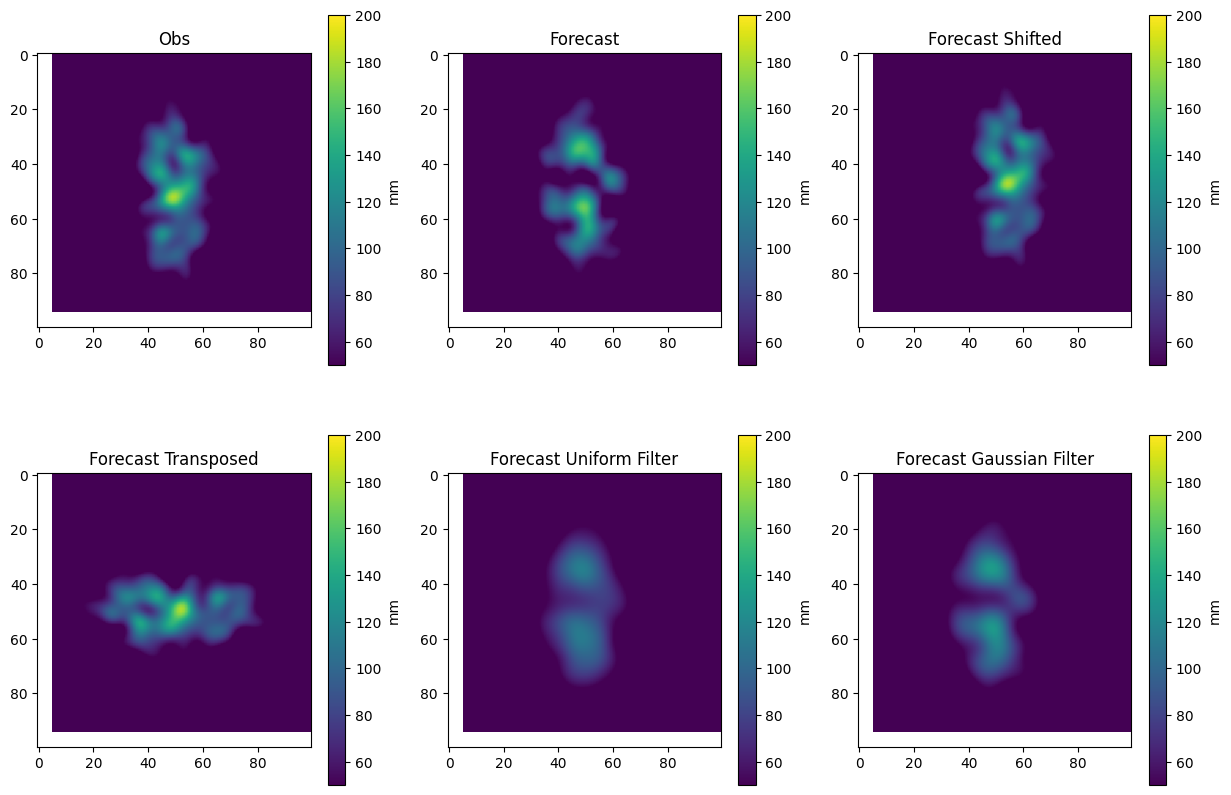

In [3]:
VIM_BLOB = 50


def create_accum_like_obj():
    # Create coordinate arrays
    x = np.linspace(-1, 1, X_LEN)
    y = np.linspace(-1, 1, Y_LEN)
    xv, yv = np.meshgrid(x, y)
    # Define the oval equation with increasing intensity towards the center
    oval = np.exp(-((yv**2) / 0.6**2 + (xv**2) / 0.3**2)) * 450
    # Generate random noise
    noise = np.random.normal(0, 1, size=(X_LEN, Y_LEN))
    # Apply Gaussian filter to create blobby effect
    blobby_noise = gaussian_filter(noise, sigma=3)
    blobby_noise = blobby_noise - np.min(blobby_noise)
    accum = oval * blobby_noise
    da = xr.DataArray(
        accum, dims=["y", "x"], coords={"y": np.arange(Y_LEN), "x": np.arange(X_LEN)}
    )
    return da


# Create the DataArray
obs = create_accum_like_obj()

# Generate perfect forecast that is offset by 5 in x and -5 in y
fcst = obs.copy()
fcst_shifted = fcst.shift(x=5, y=-5)

# Create a fcst that is the observations transposed
fcst_transposed = fcst.transpose("x", "y")
fcst_transposed = fcst_transposed.rename({"x": "y", "y": "x"})

# Create fcst from the same distirbution
fcst = create_accum_like_obj()

fcst_uniform_filter = xr.apply_ufunc(
    uniform_filter, fcst, kwargs=dict(size=NEIGHBORHOOD * 2)
)
fcst_gaussian_filter = xr.apply_ufunc(gaussian_filter, fcst, kwargs=dict(sigma=3))
obs, fcst, fcst_shifted, fcst_transposed, fcst_uniform_filter, fcst_gaussian_filter = (
    broadcast_and_match_nan(
        obs,
        fcst,
        fcst_shifted,
        fcst_transposed,
        fcst_uniform_filter,
        fcst_gaussian_filter,
    )
)

# clim fcst
fcst_clim = data = np.full((Y_LEN, X_LEN), obs.mean().values)
fcst_clim = xr.DataArray(
    fcst_clim, dims=("y", "x"), coords={"x": np.arange(X_LEN), "y": np.arange(Y_LEN)}
)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot obs
im1 = axs[0, 0].imshow(obs, vmin=VIM_BLOB, vmax=ACCUM_CONVECTION_VMAX)
axs[0, 0].set_title("Obs")

# Plot fcst
im2 = axs[0, 1].imshow(fcst, vmin=VIM_BLOB, vmax=ACCUM_CONVECTION_VMAX)
axs[0, 1].set_title("Forecast")

# Plot fcst_shifted
im3 = axs[0, 2].imshow(fcst_shifted, vmin=VIM_BLOB, vmax=ACCUM_CONVECTION_VMAX)
axs[0, 2].set_title("Forecast Shifted")

# Plot fcst_transposed
im4 = axs[1, 0].imshow(fcst_transposed, vmin=VIM_BLOB, vmax=ACCUM_CONVECTION_VMAX)
axs[1, 0].set_title("Forecast Transposed")

# Plot fcst_uniform_filter
im5 = axs[1, 1].imshow(fcst_uniform_filter, vmin=VIM_BLOB, vmax=ACCUM_CONVECTION_VMAX)
axs[1, 1].set_title("Forecast Uniform Filter")

# Plot fcst_gaussian_filter
im6 = axs[1, 2].imshow(fcst_gaussian_filter, vmin=VIM_BLOB, vmax=ACCUM_CONVECTION_VMAX)
axs[1, 2].set_title("Forecast Gaussian Filter")

# Add colorbars
fig.colorbar(im1, ax=axs[0, 0], label="mm")
fig.colorbar(im2, ax=axs[0, 1], label="mm")
fig.colorbar(im3, ax=axs[0, 2], label="mm")
fig.colorbar(im4, ax=axs[1, 0], label="mm")
fig.colorbar(im5, ax=axs[1, 1], label="mm")
fig.colorbar(im6, ax=axs[1, 2], label="mm")

plt.show()

In [4]:
ACCUM_NEIGHBORHOOD = 21

# Create ensembles
fcst_ens = create_neighourhood_ensemble(fcst, ACCUM_NEIGHBORHOOD)
fcst_shifted_ens = create_neighourhood_ensemble(fcst_shifted, ACCUM_NEIGHBORHOOD)
fcst_transposed_ens = create_neighourhood_ensemble(fcst_transposed, ACCUM_NEIGHBORHOOD)
fcst_uniform_filter_ens = create_neighourhood_ensemble(
    fcst_uniform_filter, ACCUM_NEIGHBORHOOD
)
fcst_gaussian_filter_ens = create_neighourhood_ensemble(
    fcst_gaussian_filter, ACCUM_NEIGHBORHOOD
)
fcst_clim_ens = create_neighourhood_ensemble(fcst_clim, ACCUM_NEIGHBORHOOD)

In [5]:
fcst_ens.to_netcdf("../sample_data/fcst_ens.nc")
obs.to_netcdf("../sample_data/obs.nc")

In [6]:
fcst = xr.open_dataarray(
    "../sample_data/fcst_ens.nc", chunks={"x": 100, "y": 100, "ens_mem": 100}
)
obs = xr.open_dataarray("../sample_data/obs.nc", chunks={"x": 100, "y": 100})
crps = crps_for_ensemble(fcst, obs, ensemble_member_dim="ens_mem")
crps

<xarray.DataArray ()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [7]:
crps.compute()

2024-08-30 09:21:14,652 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.91 GiB -- Worker memory limit: 4.00 GiB
2024-08-30 09:21:14,942 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 3.32 GiB -- Worker memory limit: 4.00 GiB
2024-08-30 09:21:15,031 - distributed.worker.memory - WARNING - Worker is at 64% memory usage. Resuming worker. Process memory: 2.58 GiB -- Worker memory limit: 4.00 GiB
2024-08-30 09:21:15,543 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memo

<xarray.DataArray ()>
array(7.07566508)

In [ ]:
crps = crps_for_ensemble(fcst.compute(), obs.compute(), ensemble_member_dim="ens_mem")